<a href="https://colab.research.google.com/github/Lindronics/honours_project/blob/master/notebooks/analysis/Animal_classifier_10_Artificial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animal classifier

## Setup and imports



In [0]:
%tensorflow_version 2.x

In [4]:
!rm -rf /content/*
!wget --no-check-certificate -O animals_train_final.zip "https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21230244&authkey=ALJGkjjp2SmxjW4"
!wget --no-check-certificate -O animals_train_autoencoder.zip "https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21230245&authkey=AEgMTGFYD26duxQ"
!wget --no-check-certificate -O animals_test_final.zip "https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21230243&authkey=ADV07tX3wXwmS7I"
print("=> Fetched data")
!unzip -q animals_train_final.zip
print("=> Unzipped train data")
!unzip -q animals_train_autoencoder.zip
print("=> Unzipped artificial train data")
!unzip -q animals_test_final.zip
print("=> Unzipped test data")

--2020-03-30 13:43:14--  https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21230244&authkey=ALJGkjjp2SmxjW4
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://qr7pug.am.files.1drv.com/y4mW7LE0gvVOBtEa-5p5sOOEsTvv0nuIW4pHO8G7T1tghFmDW6Z1PYgcQXgC_-rYbXEsc1lFkYWupXGI0QUf7xmd5CrN8Xc5GpccP_Tc9666zIZz6tHozExckuJVqppaJxUZArmwEkAh7uYg6IgAHc7eOP4kbm0NbY-9Y8JyxTujC604agC7fkaSrfWsO2d4UFkeacaUl-5p7pDJr1OOUN6Lg/animals_train_final.zip?download&psid=1 [following]
--2020-03-30 13:43:14--  https://qr7pug.am.files.1drv.com/y4mW7LE0gvVOBtEa-5p5sOOEsTvv0nuIW4pHO8G7T1tghFmDW6Z1PYgcQXgC_-rYbXEsc1lFkYWupXGI0QUf7xmd5CrN8Xc5GpccP_Tc9666zIZz6tHozExckuJVqppaJxUZArmwEkAh7uYg6IgAHc7eOP4kbm0NbY-9Y8JyxTujC604agC7fkaSrfWsO2d4UFkeacaUl-5p7pDJr1OOUN6Lg/animals_train_final.zip?download&psid=1
Resolving qr7pug.am.files.1drv.com (

In [35]:
!rm -rf honours_project
!git clone https://github.com/Lindronics/honours_project
!cp honours_project/models/classification/trans_cfg.py .

Cloning into 'honours_project'...
remote: Enumerating objects: 273, done.
remote: Counting objects: 100% (273/273), done.
remote: Compressing objects: 100% (205/205), done.
remote: Total 1697 (delta 144), reused 187 (delta 66), pack-reused 1424
Receiving objects: 100% (1697/1697), 76.14 MiB | 31.25 MiB/s, done.
Resolving deltas: 100% (914/914), done.


In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns; sns.set()
import os
from os import listdir
from os.path import isdir, join
import shutil
from tqdm import tqdm
from datetime import datetime
import random

from itertools import count
from collections import defaultdict

from honours_project.models.classification.models import AbstractModel, ResNet
from honours_project.models.classification.dataset import Dataset

In [37]:
from honours_project.preprocessing.generate_labels import generate_labels, write_labels

filter_fn = lambda x: x.split("_")[0] in ["pony", "alpaca", "chicken"]

write_labels(generate_labels(filter_fn, "animals_test_final/images", channel_prefix=False), "animals_test_final/labels.txt")
write_labels(generate_labels(filter_fn, "animals_train_final/images", channel_prefix=False), "animals_train_final/labels.txt")
write_labels(generate_labels(filter_fn, "animals_train_autoencoder/images", channel_prefix=False), "animals_train_autoencoder/labels.txt")

Dataset composition:
 - pony: 	61
 - muscovy-duck: 	0
 - alpaca: 	87
 - silkie-chicken: 	0
 - hamburg-chicken: 	0
 - cat: 	0
 - chicken: 	119
 - goose: 	0
267 items total.
Dataset composition:
 - pony: 	415
 - muscovy-duck: 	0
 - alpaca: 	377
 - silkie-chicken: 	0
 - hamburg-chicken: 	0
 - cat: 	0
 - chicken: 	277
 - goose: 	0
1069 items total.
Dataset composition:
 - pony: 	425
 - muscovy-duck: 	0
 - alpaca: 	377
 - silkie-chicken: 	0
 - hamburg-chicken: 	0
 - cat: 	0
 - chicken: 	277
 - goose: 	0
1079 items total.


## Dataset

In [0]:
def train(train_labels, test_labels, epochs=80, register=True, batch_size=16):
    train_data = Dataset(train_labels, rgb_only=False, split=False, res=(120, 160), register=register, batch_size=batch_size)
    test_data = Dataset(test_labels, rgb_only=False, split=False, res=(120, 160), register=register, batch_size=batch_size)

    X, y = train_data.get_all()
    X_test, y_test = test_data.get_all()

    model = ResNet("fusion", train_data.num_classes(), train_data.shape(), None).get_model()
    optimizer = K.optimizers.Adam(learning_rate=0.000001, epsilon=0.005)
    # optimizer = K.optimizers.SGD(decay=1e-6)
    model.compile(optimizer=optimizer,
                loss="categorical_crossentropy",
                metrics=["accuracy"])

    tf.random.set_seed(42)
    np.random.seed(42)


    hist = model.fit(X, y, epochs=epochs, validation_data=(X_test, y_test), batch_size=batch_size)
    return model, hist.history

In [48]:
train_sets = [
    ("normal", "animals_train_final/labels.txt"),
    ("artificial", "animals_train_autoencoder/labels.txt"),
]

results = {}

for i, labels in train_sets:
    model, hist = train(labels, "animals_test_final/labels.txt", epochs=60, register=False, batch_size=32)
    results[i] = {"model": model, "hist": hist}

Epoch 1/60
33/33 [==============================] - 1s 45ms/step - loss: 2.4053 - accuracy: 0.3239 - val_loss: 1.0986 - val_accuracy: 0.3008
Epoch 2/60
33/33 [==============================] - 1s 32ms/step - loss: 1.9524 - accuracy: 0.3494 - val_loss: 1.1194 - val_accuracy: 0.2148
Epoch 3/60
33/33 [==============================] - 1s 32ms/step - loss: 1.7279 - accuracy: 0.3996 - val_loss: 1.1464 - val_accuracy: 0.2148
Epoch 4/60
33/33 [==============================] - 1s 31ms/step - loss: 1.5902 - accuracy: 0.4290 - val_loss: 1.1576 - val_accuracy: 0.2070
Epoch 5/60
33/33 [==============================] - 1s 31ms/step - loss: 1.4281 - accuracy: 0.4688 - val_loss: 1.1406 - val_accuracy: 0.2148
Epoch 6/60
33/33 [==============================] - 1s 31ms/step - loss: 1.3499 - accuracy: 0.4867 - val_loss: 1.1104 - val_accuracy: 0.3203
Epoch 7/60
33/33 [==============================] - 1s 31ms/step - loss: 1.3118 - accuracy: 0.5152 - val_loss: 1.0864 - val_accuracy: 0.4648
Epoch 8/60
33

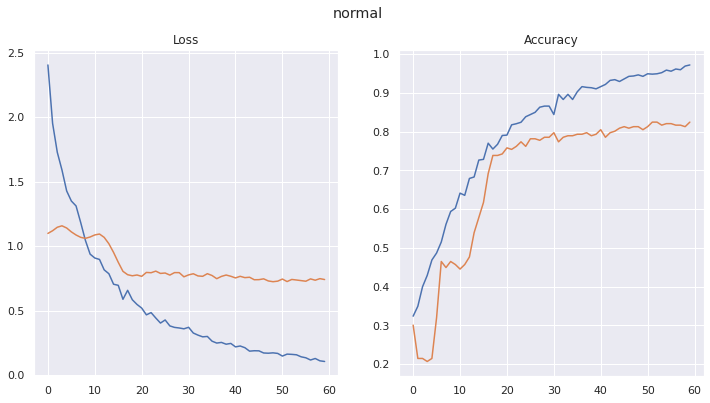

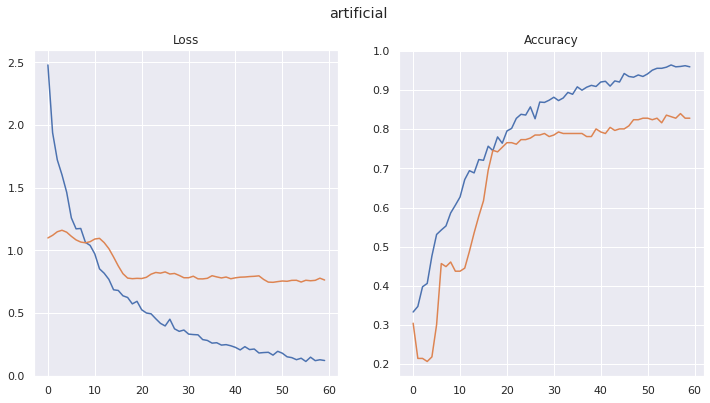

In [51]:
  for a in results:
    hist = results[a]["hist"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(hist["loss"], label="train")
    ax1.plot(hist["val_loss"], label="val")
    ax1.set_title("Loss")

    ax2.plot(hist["accuracy"], label="train")
    ax2.plot(hist["val_accuracy"], label="val")
    ax2.set_title("Accuracy")
    fig.suptitle(a)

              precision    recall  f1-score   support

        pony       0.73      0.80      0.77        55
      alpaca       1.00      0.60      0.75        83
     chicken       0.80      0.99      0.89       118

    accuracy                           0.82       256
   macro avg       0.84      0.80      0.80       256
weighted avg       0.85      0.82      0.82       256



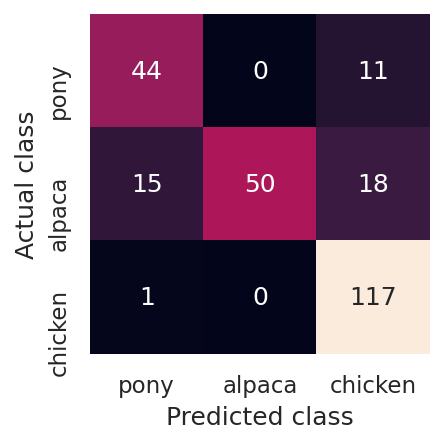

In [71]:
test_data = Dataset("animals_test_final/labels.txt", rgb_only=False, split=False, res=(120, 160), register=False, batch_size=32)
model = results["normal"]["model"]

y_pred = np.argmax(model.predict(test_data), axis=1)
y_test_ = test_data.get_labels()[:y_pred.shape[0]]
print(classification_report(y_test_, y_pred, target_names=test_data.class_labels))

# confusion
y_pred_named = [test_data.class_labels[x] for x in y_pred]
y_test_named = [test_data.class_labels[x] for x in y_test_]
confusion = confusion_matrix(y_test_named, y_pred_named, labels=test_data.class_labels)

f, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax = sns.heatmap(confusion, annot=True, xticklabels=test_data.class_labels, yticklabels=test_data.class_labels, square=True, cbar=False, fmt="d")
ax.set(xlabel='Predicted class', ylabel='Actual class')
f.savefig("confusion_normal.pdf", bbox_inches="tight")
plt.show()

              precision    recall  f1-score   support

        pony       0.69      0.87      0.77        55
      alpaca       1.00      0.60      0.75        83
     chicken       0.84      0.97      0.90       118

    accuracy                           0.83       256
   macro avg       0.84      0.81      0.81       256
weighted avg       0.86      0.83      0.82       256



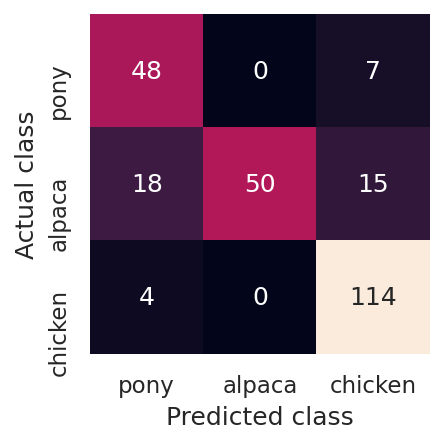

In [72]:
test_data = Dataset("animals_test_final/labels.txt", rgb_only=False, split=False, res=(120, 160), register=False, batch_size=32)
model = results["artificial"]["model"]

y_pred = np.argmax(model.predict(test_data), axis=1)
y_test_ = test_data.get_labels()[:y_pred.shape[0]]
print(classification_report(y_test_, y_pred, target_names=test_data.class_labels))

# confusion
y_pred_named = [test_data.class_labels[x] for x in y_pred]
y_test_named = [test_data.class_labels[x] for x in y_test_]
confusion = confusion_matrix(y_test_named, y_pred_named, labels=test_data.class_labels)

f, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax = sns.heatmap(confusion, annot=True, xticklabels=test_data.class_labels, yticklabels=test_data.class_labels, square=True, cbar=False, fmt="d")
ax.set(xlabel='Predicted class', ylabel='Actual class')
f.savefig("confusion_autoencoder.pdf", bbox_inches="tight")
plt.show()